In [1]:
!pip install torch datasets torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import copy

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------------------------
# This script demonstrates the basic setup for training a model
# on an image classification task using PyTorch and transfer
# learning techniques. It uses pre-trained models from the
# torchvision library (e.g., ResNet) and fine-tunes them for
# the specific dataset.

# -------------------------------------------------------------
# Libraries used:
# - torch: Provides deep learning framework for defining models,
#   performing forward and backward propagation, and optimizing weights.
# - torchvision: Contains datasets, models, and image transformations
#   utilities.
# - matplotlib: Used for visualizing training results such as accuracy
#   and loss.
# - numpy: Handles array operations.
# -------------------------------------------------------------

"""
This section checks whether a CUDA-enabled GPU is available.
If so, it sets the device to 'cuda', otherwise it defaults to 'cpu'.

torch.cuda.is_available():
    - Returns True if GPU with CUDA support is available.
torch.device():
    - Creates a device object to specify whether tensors and models
      should be run on a GPU ('cuda') or CPU ('cpu').
"""

Using device: cuda:0


"\nThis section checks whether a CUDA-enabled GPU is available.\nIf so, it sets the device to 'cuda', otherwise it defaults to 'cpu'.\n\ntorch.cuda.is_available():\n    - Returns True if GPU with CUDA support is available.\ntorch.device():\n    - Creates a device object to specify whether tensors and models\n      should be run on a GPU ('cuda') or CPU ('cpu').\n"

In [3]:
# ---------------- DATA PREPROCESSING AND LOADING ----------------
"""
In this section, we will prepare and load the MNIST dataset.
The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9).
Since ResNet models are designed to work with 224x224 images, we need to resize
each MNIST image to match this input size.

We will perform three main steps:
1. Resize: Change the size of the image from 28x28 to 224x224.
2. ToTensor: Convert the image from its original format to a PyTorch tensor (multi-dimensional array).
3. Normalize: Adjust the pixel values so they range between -1 and 1 to stabilize training.

Next, we download and load the MNIST dataset.
- train_dataset: This is the dataset used to train the model. It consists of 60,000 images.
- val_dataset: This is the validation dataset, which has 10,000 images that will be used to test how well the model performs after training.

root='./data':
    - Specifies where the dataset should be stored on the computer. Here, the 'data' folder is used.
train=True / train=False:
    - Indicates whether the dataset is used for training (True) or validation/testing (False).
download=True:
    - Downloads the dataset if it is not already available.
transform=transform:
    - Applies the transformations (resize, convert to tensor, normalize) to the dataset.

"""

# Modify the transformation to convert 1-channel grayscale images into 3-channel RGB images
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 for ResNet
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for 3 channels
])

# Download and load the training and validation datasets again with the updated transformation
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 10583908.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350708.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3232623.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4343485.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
"""
A DataLoader is used to load the dataset in small batches during training and validation.
- train_loader: Loads the training data in batches of 32 images, shuffling the data to ensure the model learns from a variety of examples in each batch.
- val_loader: Loads the validation data in batches of 32 images, but does not shuffle because the order of images doesn't matter for validation.

batch_size=32:
    - Specifies the number of images processed in each batch.
shuffle=True / False:
    - shuffle=True randomly shuffles the training data so that the model doesn't see images in the same order each time.
    - shuffle=False keeps the order unchanged for the validation data.
"""

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
"""
The dataset_sizes dictionary stores the number of images in the training and validation datasets.
- train: 60,000 images for training.
- val: 10,000 images for validation.
These values are useful for tracking the model's progress during training.

The class_names list contains the names of the classes (digits 0-9). Each class represents a digit label in the MNIST dataset.
"""

# Sizes of the datasets
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Class names: digits 0 to 9
class_names = [str(i) for i in range(10)]

In [6]:
"""
The dataloaders dictionary holds the train and validation DataLoader objects.
This allows easy access to both loaders when training and validating the model.
"""

# Dataloader dictionary containing train and validation DataLoader
dataloaders = {'train': train_loader, 'val': val_loader}

**Data Transformations:** Before feeding the images into the model, they must be resized to fit the model's expected input size (224x224 pixels). The images are also normalized so that the pixel values range between -1 and 1, which helps the model learn more effectively.

**Data Loading:** The data is split into two parts:

**Training Dataset:** This is the data the model will use to learn patterns.

**Validation Dataset:** This is separate data used to evaluate how well the model is performing without affecting the training process.
Batches: Instead of feeding all the images at once, they are processed in smaller groups (32 images per batch), which is more memory efficient.

In [7]:

"""
In this section we are going to load a pre-trained ResNet50 model.
- ResNet50 is a powerful convolutional neural network (CNN) architecture that has already been trained on a large dataset (ImageNet).
- By using a pre-trained model, we leverage the knowledge it has already learned and fine-tune it for our specific task (classifying MNIST digits).

We will modify the last layer of ResNet50 to match the number of classes in MNIST (10 classes, one for each digit: 0-9).
"""

# Load a pre-trained ResNet50 model from torchvision
# pretrained=True: This loads the model weights pre-trained on ImageNet dataset
model_ft = models.resnet50(pretrained=True)

"""
The pre-trained ResNet50 model was originally designed to classify 1,000 different objects in the ImageNet dataset.
Since the MNIST dataset only has 10 different classes (digits 0-9), we need to replace the final layer (fully connected layer) of the network.

- The fully connected layer (fc) is responsible for classifying the images into specific categories.
- To replace it, we first need to find out how many input features this layer expects, which is given by 'model_ft.fc.in_features'.
- We then create a new fully connected layer that outputs 10 classes, matching MNIST's 10 digits.
"""

# Get the number of input features for the final fully connected layer
num_ftrs = model_ft.fc.in_features

# Replace the final fully connected layer with a new one that has 10 output classes (for digits 0-9)
model_ft.fc = nn.Linear(num_ftrs, 10)  # nn.Linear creates a fully connected layer

"""
Finally, we move the model to the selected device (either GPU if available, or CPU).
This ensures that the model computations happen on the right hardware.
"""

model_ft = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


**Pre-trained Models:** A pre-trained model (ResNet50 in this case) has already been trained on a large, diverse dataset (ImageNet), so it knows how to identify various patterns in images. Instead of starting from scratch, we "fine-tune" the model for our specific task (classifying MNIST digits).

**Fully Connected Layer**: This is the final layer in the model, where all the learned information is condensed to make a decision (in this case, to predict one of the 10 possible digits).

**Modifying for MNIST**: Since the pre-trained model was designed for 1,000 classes, we need to modify the last layer to match the 10 classes in the MNIST dataset.

In [8]:

"""
In this section, we define two key components for training our model:
1. **Loss Function**: The loss function measures how far the model's predictions are from the true labels. For classification tasks like MNIST, we use CrossEntropyLoss.
2. **Optimizer**: The optimizer updates the model's weights based on the loss during training. Here, we use the Stochastic Gradient Descent (SGD) optimizer.
3. **Learning Rate Scheduler**: This automatically adjusts the learning rate during training to make the model learn more efficiently.

Let's go through these components in detail:
"""

"""
- nn.CrossEntropyLoss is a common loss function for multi-class classification tasks.
- It compares the predicted probabilities for each class with the true label and calculates a loss value.
- The lower the loss, the better the model's predictions.
"""
criterion = nn.CrossEntropyLoss()

"""
- The optimizer updates the weights of the model during training based on the loss.
- Stochastic Gradient Descent (SGD) is one of the most commonly used optimization algorithms.
- Learning rate (lr=0.001): Controls how big the steps are during optimization. A smaller learning rate helps fine-tune the model more gradually.
- Momentum (momentum=0.9): Helps the optimizer navigate faster by keeping track of the previous steps and pushing the optimization in the same direction if it's beneficial.
"""
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

"""
- A learning rate scheduler adjusts the learning rate during training to improve efficiency.
- StepLR reduces the learning rate by a factor of gamma (0.1) every 'step_size' (7 epochs in this case).
- As the model improves, the learning rate is reduced to allow for finer updates to the weights.
"""
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


**Loss Function (CrossEntropyLoss)**: This function tells the model how wrong its predictions are. The model's goal is to minimize this loss by adjusting its weights.

**Optimizer (SGD)**: Think of the optimizer as the engine that drives the model to learn. It updates the model's weights based on how much the model is getting wrong (based on the loss function).

**Learning Rate and Momentum:** The learning rate determines how big the steps are when updating the model's weights. Momentum helps smooth out the learning process, allowing the model to make more consistent progress.

**Learning Rate Scheduler**:  As the model gets better, the learning rate is automatically reduced to allow for more fine-tuned learning.

In [9]:
"""
This function is for training the model and evaluating it at each epoch.
- An epoch is one complete pass over the entire training dataset.
- The function alternates between two phases in each epoch:
  1. **Training phase**: The model learns from the training dataset.
  2. **Validation phase**: The model is evaluated on the validation dataset to see how well it generalizes.

The process involves:
- Forward pass: Making predictions based on the input data.
- Backward pass: Updating the model weights based on how wrong the predictions were (during training phase only).
- Loss and accuracy calculation: Measuring how good the model's predictions are.
- Best model selection: Keeping track of the best model by comparing the validation accuracy after each epoch.
"""

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    """
    Args:
        model: The neural network model to be trained.
        criterion: The loss function (CrossEntropyLoss) used to calculate the loss.
        optimizer: Optimizer (SGD) used to update the model weights.
        scheduler: Learning rate scheduler to adjust the learning rate after each epoch.
        num_epochs: Number of epochs (iterations over the entire dataset).

    Returns:
        model: The best model obtained during training (based on validation accuracy).
    """

    # Save a copy of the best model's weights
    best_model_wts = copy.deepcopy(model.state_dict())

    # Initialize the best accuracy to 0
    best_acc = 0.0

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode (enables gradient updates)
            else:
                model.eval()  # Set model to evaluation mode (disables gradient updates)

            running_loss = 0.0  # Cumulative loss for the current epoch
            running_corrects = 0  # Correct predictions in the current epoch

            # Loop over the data (inputs and labels) in the DataLoader
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
                labels = labels.to(device)  # Move labels to the device

                # Zero out any previously calculated gradients
                optimizer.zero_grad()

                # Forward pass (predict the outputs)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Get the model's predictions
                    _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score
                    loss = criterion(outputs, labels)  # Calculate the loss

                    # Backward pass and optimization in the training phase
                    if phase == 'train':
                        loss.backward()  # Compute the gradients
                        optimizer.step()  # Update the model weights

                # Track the loss and accuracy
                running_loss += loss.item() * inputs.size(0)  # Multiply loss by batch size
                running_corrects += torch.sum(preds == labels.data)  # Sum the correct predictions

            # Calculate epoch-level loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]  # Average loss over all data points
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # Accuracy: correct predictions / total samples

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if the validation accuracy has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step the learning rate scheduler to adjust the learning rate
        scheduler.step()

    # Load the best model weights (the one with the highest validation accuracy)
    model.load_state_dict(best_model_wts)

    # Return the best model after training
    return model

**Epoch:** One complete iteration over the training dataset. We repeat this process multiple times to allow the model to learn and improve.

**Training vs. Validation:**

T**raining phase**: The model learns by adjusting its weights based on the error (loss).

**Validation phase**: The model is tested on unseen data to check how well it generalizes (no learning happens here).

**Forward pass**: The model makes predictions based on input data.

**Backward pass**: In the training phase, the model updates its weights by calculating how far its predictions are from the true labels (using the optimizer).

**Loss**: A measure of how wrong the model's predictions are. The goal is to minimize this loss.

**Accuracy**: Measures how many predictions the model got right. Higher accuracy means better performance.

**Best Model**: The model that performs the best on the validation set (highest accuracy) is saved and returned at the end.

In [11]:

"""
In this step, we train the model for 10 epochs using the train_model function.
The model will be trained using the following:
1. **model_ft**: The pre-trained ResNet50 model, modified for the MNIST dataset.
2. **criterion**: The loss function (CrossEntropyLoss), which measures how far the model's predictions are from the true labels.
3. **optimizer_ft**: The Stochastic Gradient Descent (SGD) optimizer that updates the model's weights.
4. **exp_lr_scheduler**: The learning rate scheduler that automatically adjusts the learning rate every 7 epochs.
5. **num_epochs=10**: The number of times the model will go through the training dataset.

The function returns the model that performs best on the validation dataset.
"""

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)


Epoch 0/0
----------
train Loss: 0.0199 Acc: 0.9946
val Loss: 0.0147 Acc: 0.9956


**Training**:

The model will now be trained on the MNIST dataset for 1 epochs. This means the model will look at all the images in the training set 1 times to learn from them.

**Validation**:

 After each epoch, the model is tested on the validation dataset to check how well it performs on unseen data. If the model improves, it saves the best version of itself.

**Result**:

 After 1 epochs, the best model (the one that performed the best on the validation data) will be saved and ready for evaluation or further use.

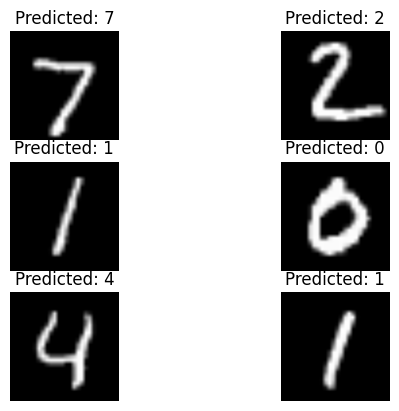

In [12]:
"""
This function visualizes the model's predictions on a few images from the validation set.
It shows the images along with the predicted labels.

Parameters:
    model (torch.nn.Module): The trained model used for making predictions.
    num_images (int): The number of images to visualize. Default is 6.
"""

def visualize_model(model, num_images=6):
    """
    Visualizes the predictions of the trained model on a few validation images.

    Parameters:
        model (torch.nn.Module): The trained model.
        num_images (int): The number of images to visualize.
    """
    # Save the model's current training state to restore later
    was_training = model.training
    model.eval()  # Set model to evaluation mode (disables gradient updates)

    images_so_far = 0
    fig = plt.figure()  # Create a new figure for plotting images

    with torch.no_grad():  # No need to compute gradients during visualization
        # Iterate over batches of validation data
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
            labels = labels.to(device)  # Move labels to the device

            outputs = model(inputs)  # Get the model's predictions
            _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score

            # Loop over the images in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)  # Create a subplot for each image
                ax.axis('off')  # Hide the axis
                ax.set_title(f'Predicted: {class_names[preds[j]]}')  # Set the title to the predicted class
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))  # Convert tensor to numpy array and adjust dimensions
                plt.imshow(img * 0.5 + 0.5)  # Unnormalize the image and display it

                # Stop once the required number of images are displayed
                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the model's training state
                    return

        # Restore the model's training state if not enough images were processed
        model.train(mode=was_training)

# Visualize predictions
visualize_model(model_ft)


 - model.eval(): This puts the model in evaluation mode, which disables certain behaviors used only during training (like dropout).

 - torch.no_grad(): This context manager is used to turn off gradient calculations, which are unnecessary for visualization and save computation time.

**Plotting**:
 - plt.subplot(): Creates a grid of plots. num_images // 2, 2 ensures the images are arranged in a grid format.
ax.axis('off'): Hides the axis for a cleaner look.
ax.set_title(): Sets the title of each subplot to show the model’s prediction.

**Normalization:**
 - plt.imshow(img * 0.5 + 0.5): The images were normalized during transformation (values between -1 and 1). This step reverses the normalization to display the image correctly.

**Restoring Training State:**
 - model.train(mode=was_training): Restores the model to its original training state after visualization.

In [13]:
!pip freeze > requirements.txt

In [15]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Conclusion:**

By combining concepts from the paper with practical implementation in PyTorch, I trained a ResNet50 model using transfer learning on the MNIST dataset. I was able to fine-tune a pre-trained model and visualize its predictions on the MNIST validation set. This approach showcases the effectiveness of transfer learning as highlighted in the paper, making it possible to achieve good results even with a relatively small dataset like MNIST.